In [1]:

####################################################################################################
####################################################################################################

import sys
import os.path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display
from IPython.display import Image

import tensorflow as tf

print (tf.__version__)

import keras
import keras.utils.vis_utils
from keras import backend as K
from keras import layers
from keras import regularizers
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import load_model
from keras.models import Sequential
from keras.utils import plot_model


1.4.1


Using TensorFlow backend.


In [13]:

####################################################################################################
####################################################################################################

file_all = "../pax_waveform_simulator/merged/merged_all.pkl"

df_all   = pd.read_pickle(file_all)
df_all   = df_all[df_all['s2_exists'] == True]


####################################################################################################
####################################################################################################

#df_train_truth = pd.DataFrame.from_csv("../python_pax_reader/data/train_truth_v2.csv")
#df_train_input = pd.DataFrame.from_csv("../python_pax_reader/data/train_input_v2.csv")


####################################################################################################
####################################################################################################

df_train_truth = df_all[:][['x', 'y']]


####################################################################################################
####################################################################################################

df_train_input = df_all.iloc[:, 14:]


##########################################################################################
##########################################################################################

print(df_train_input.shape)
print(df_train_truth.shape)


####################################################################################################
# First 127 are S2
####################################################################################################

df_train_input = df_train_input.iloc[:, 0:127]
df_train_input.shape



(24858, 127)
(24858, 2)


(24858, 127)

,x,y
0,4.628629,27.725661
1,2.626434,-17.960824
2,-32.844888,-21.247503
3,10.907536,-6.312277
4,12.190372,-35.645256


,s2_area_000,s2_area_001,s2_area_002,s2_area_003,s2_area_004,s2_area_005,s2_area_006,s2_area_007,s2_area_008,s2_area_009,...,s2_area_117,s2_area_118,s2_area_119,s2_area_120,s2_area_121,s2_area_122,s2_area_123,s2_area_124,s2_area_125,s2_area_126
0,0.671548,0.0,0.0,2.496256,1.487787,0.000000,0.000000,1.308374,0.000000,4.030403,...,0.000000,0.0,1.953594,1.179322,4.001881,0.000000,1.197742,0.000000,1.376309,2.341697
1,1.996201,0.0,0.0,1.249075,0.000000,2.174994,1.464755,5.756495,1.124437,0.000000,...,3.401516,0.0,1.277412,5.448813,1.011515,5.978631,33.596052,12.064080,5.395413,14.160685
2,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.989659,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.559474,0.000000,2.160293,0.000000
3,0.000000,0.0,0.0,1.302799,0.000000,2.039580,0.000000,1.443872,0.000000,0.685812,...,3.825090,0.0,2.068674,2.355067,16.410299,108.660534,38.487834,11.907051,0.000000,12.058119
4,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.707680,0.000000,...,0.000000,0.0,3.527586,1.272160,0.000000,1.262067,2.456829,1.218938,2.265206,1.221793


(24858,)


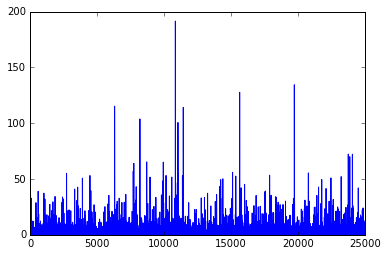

In [14]:

####################################################################################################
####################################################################################################

nRows = 5

#print()
display(df_train_truth[0:nRows][:])
#print()
display(df_train_input[0:nRows][:])
#print()

for i in range(0, 1):
    
    arr = df_train_input.iloc[:, i]
    print(arr.shape)
    plt.plot(arr)


In [23]:

##########################################################################################
# From Xenon1T
##########################################################################################

inputDim = 127

def MLP(
    activation='elu', 
    reg_scale=0.00100, # Regularization on coefficients
    keep_rate=0.00005, # The smaller the keep rate, the better the performance is
    noutput=2):
        

    name = 'xenon1t'
    
    ######################################################################################
    # hidden layers to use, for reference, Yuehuan used [32,28]
    ######################################################################################
    
    hidden = [100, 80, 40, 20]
    

    ######################################################################################
    # create sequential model
    ######################################################################################
    
    model = Sequential() 
    
    model.add(
        Dense(
            inputDim,
            input_dim=inputDim
        )
    )

    for hid in hidden:
        model.add(
            Dense(
                hid,
                kernel_initializer='normal',
                activation=activation,
                bias_initializer='zeros',
                use_bias=True,
                kernel_regularizer = regularizers.l2(reg_scale)
            )
        )
        
        model.add(Dropout(keep_rate))
        
    model.add(Dense(noutput)) # Output layer
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model, name

mlp = MLP()


##########################################################################################
##########################################################################################

def bargeModel():

    reg_scale = 0.001 # possibly bad
    
    bias_init = 'zeros'
    bias_use  = True
    kern_reg  = regularizers.l2(reg_scale)
    
    
    act = 'elu'

    keep_rate=0.00005
    
    name = 'barge'
    
    model = Sequential()
    
    # input
    model.add(
        Dense(127, activation=act, input_dim=inputDim)
    )
    
    # hidden 1
    model.add(
        Dense(
            100,
            activation         = act,
            bias_initializer   = bias_init,
            use_bias           = bias_use,
            kernel_regularizer = kern_reg
        )
    )
    
    model.add(Dropout(keep_rate))
    
    # hidden 2
    model.add(
        Dense(
            40,
            activation         = act,
            bias_initializer   = bias_init,
            use_bias           = bias_use,
            kernel_regularizer = kern_reg
        )
    )
    
    model.add(Dropout(keep_rate))

    # hidden 3
    model.add(
        Dense(
            20,
            activation         = act,
            bias_initializer   = bias_init,
            use_bias           = bias_use,
            kernel_regularizer = kern_reg
        )
    )
    
    model.add(Dropout(keep_rate))
    
    # output
    model.add(
        Dense(2)
    )
    
    return model, name

bm = bargeModel()


In [24]:

##########################################################################################
##########################################################################################

models = [mlp, bm]

for iModel in range(0, len(models)):
    
    model = models[i]
         
    ######################################################################################
    ######################################################################################

    model, model_name = models[iModel]
    
    model.compile(loss='mean_squared_error', optimizer='adam') #, metrics=['accuracy'])
    #model.compile(loss='mean_absolute_error'            , optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='mean_absolute_percentage_error' , optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='mean_squared_logarithmic_error' , optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='squared_hinge'                  , optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='hinge'                          , optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='categorical_hinge'              , optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='logcosh'                        , optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy'       , optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='binary_crossentropy'            , optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='kullback_leibler_divergence'    , optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='poisson'                        , optimizer='adam', metrics=['accuracy'])
    #model.compile(loss='cosine_proximity'               , optimizer='adam', metrics=['accuracy'])

    
    ######################################################################################
    ######################################################################################
    
    model.summary()
    model.fit(df_train_input, df_train_truth, epochs=10, batch_size=50, verbose=1)
    print("Done")

        
    ######################################################################################
    ######################################################################################

    folder   = "models" + "/"    
    name     = 'model' + '_' + model_name + '_' + act 
    name_h5  = folder + name + ".h5"
    name_png = folder + name + ".png"

            
    ######################################################################################
    ######################################################################################
    
    model.save(name_h5, overwrite=True)
        
   
    ######################################################################################
    ######################################################################################

    plot_model(model, to_file=name_png, show_layer_names=True, show_shapes=True)
    
    Image(filename=name_png) 
    
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 127)               16256     
_________________________________________________________________
dense_46 (Dense)             (None, 100)               12800     
_________________________________________________________________
dropout_29 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 80)                8080      
_________________________________________________________________
dropout_30 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 40)                3240      
_________________________________________________________________
dropout_31 (Dropout)         (None, 40)                0         
__________